In [1]:
# import libraries
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

# Load specific forecasting tools
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime

# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# read and show the head of the dataset
df = pd.read_csv('../dataset/full_COA.csv.' , index_col='Time',parse_dates=True)
df.head()

,COA,temp,year,quarter,month,day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,
2012-01-01 01:00:00,5986.0,13.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 02:00:00,5547.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 03:00:00,5233.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 04:00:00,5150.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 05:00:00,5235.0,11.98,2012,1,1,1,0,0,0,0,0,0,1


In [3]:
# change frequency to hourly
df.index.freq = 'H'

In [4]:
# show last 5 rows
df.tail()

,COA,temp,year,quarter,month,day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,
2017-12-31 19:00:00,9495.0,18.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 20:00:00,9365.0,16.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 21:00:00,9250.0,15.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 22:00:00,8931.0,14.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 23:00:00,8679.0,12.98,2017,4,12,31,0,0,0,0,0,0,1


In [5]:
# take only megawatts 
df_l = df[['COA']]

In [6]:
# show length of dataframe
len(df_l)

52607

In [7]:
# resample to daily
df_d = df_l['COA'].resample(rule = 'D').mean()

In [8]:
# set frequency to daily
df_d.index.freq = 'D'

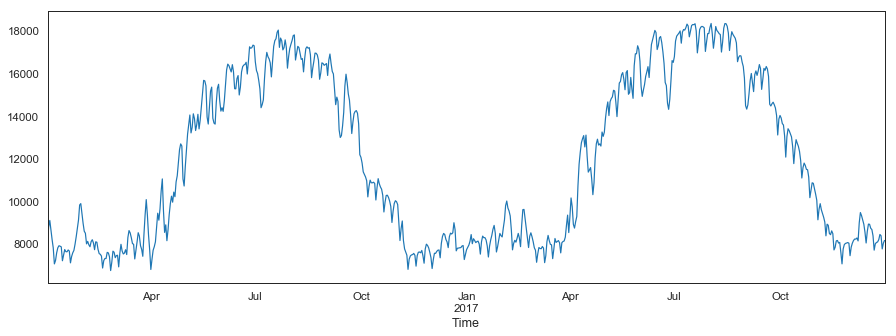

In [9]:
# plot 2 years worth of data
df_d['2016-01-01 01:00:00':].plot(figsize=(15,5)).autoscale(axis='x',tight=True)

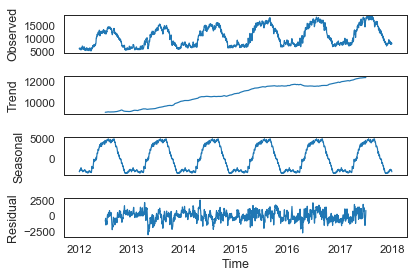

In [10]:
# seasonal decompose
seasonal_decompose(df_d, freq=365).plot();

In [11]:
# define function for Dickey-Fuller Test

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [12]:
# doing Dickey-Fuller Test
adf_test(df_d)

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.232169
p-value                    0.018197
# lags used               23.000000
# observations          2168.000000
critical value (1%)       -3.433370
critical value (5%)       -2.862874
critical value (10%)      -2.567480
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [37]:
# length of dataset
l_df = len(df_d)

In [38]:
# length to split
l_split = len(df_d['2017-01-01 00:00:00':])

In [39]:
l_df

2192

In [40]:
l_split

365

In [80]:
# train test split
dataset = df_d.values #numpy.ndarray
dataset = dataset.astype('float32') # make sure values are float
dataset = np.reshape(dataset, (-1, 1)) # reshape to vertical
scaler = MinMaxScaler(feature_range=(0, 1)) # define minmax scaler
train_size = l_df-l_split 
test_size = len(dataset) - train_size
train, test = scaler.fit_transform(dataset[0:train_size,:]), scaler.transform(dataset[train_size:len(dataset),:]) # scale data

In [81]:
l_df-l_split

1827

In [82]:
train_size

1827

In [83]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [84]:
len(train)

1827

In [85]:
len(test)

365

In [86]:
# reshape into X=t and Y=t+1
look_back = 7
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [87]:
X_train.shape

(1819, 7)

In [88]:
Y_train.shape

(1819,)

In [89]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [90]:
# network arcitichure
model = Sequential()
model.add(LSTM(160, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(15, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=30, batch_size=40, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 1819 samples, validate on 357 samples
Epoch 1/30
1819/1819 [==============================] - 1s 303us/step - loss: 0.0375 - val_loss: 0.0076
Epoch 2/30
1819/1819 [==============================] - 0s 92us/step - loss: 0.0097 - val_loss: 0.0034
Epoch 3/30
1819/1819 [==============================] - 0s 82us/step - loss: 0.0079 - val_loss: 0.0033
Epoch 4/30
1819/1819 [==============================] - 0s 84us/step - loss: 0.0076 - val_loss: 0.0036
Epoch 5/30
1819/1819 [==============================] - 0s 98us/step - loss: 0.0069 - val_loss: 0.0031
Epoch 6/30
1819/1819 [==============================] - 0s 84us/step - loss: 0.0074 - val_loss: 0.0036
Epoch 7/30
1819/1819 [==============================] - 0s 76us/step - loss: 0.0066 - val_loss: 0.0027
Epoch 8/30
1819/1819 [==============================] - 0s 89us/step - loss: 0.0062 - val_loss: 0.0026
Epoch 9/30
1819/1819 [==============================] - 0s 87us/step - loss: 0.0062 - val_loss: 0.0052
Epoch 10/30
1819/1819 [==

In [91]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

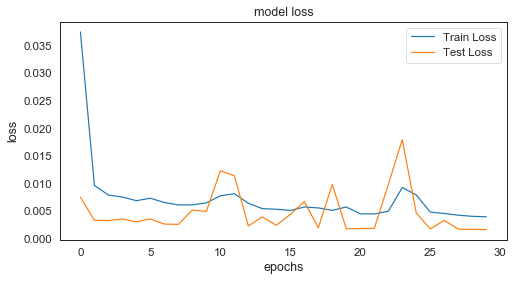

In [92]:
# plotting train and test loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

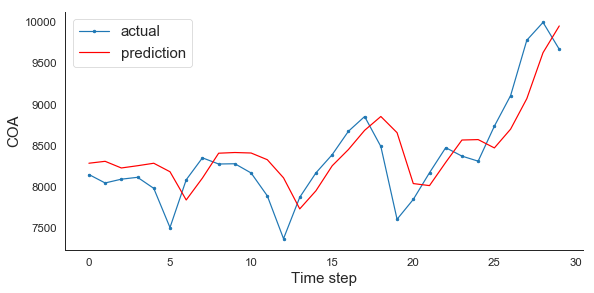

In [93]:
# plotting first k number of prediction vs test
aa=[x for x in range(30)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:30], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:30], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('COA', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
# plt.ylim(0,10000)
plt.show();


In [94]:
# make data frame for test 
tes = pd.DataFrame(Y_test.reshape(Y_test.shape[1],Y_test.shape[0]) , columns=['test'] , index= df_d.iloc[train_size+look_back:-1].index)

In [95]:
# make data frame for prediction
pre = pd.DataFrame(test_predict , columns=['pred'] , index= df_d.iloc[train_size+look_back:-1].index)

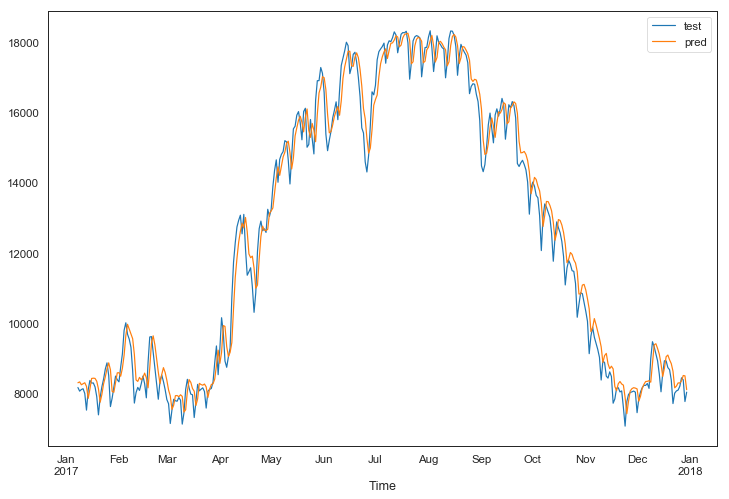

In [96]:
# plotting test vs predict
tes.test['2017-01-01 00:00:00':].plot(legend=True, figsize=(12,8))
pre.pred['2017-01-01 00:00:00':].plot(legend=True)

In [97]:
# calculate rmse
rmse(tes.test , pre.pred)

528.322923471161

In [98]:
# calculate r2
r2_score(tes.test , pre.pred)

0.9813985294791708